In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from tqdm import tqdm

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = data.DataLoader(trainset, batch_size=32, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:04<00:00, 2238409.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 143129.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2026495.88it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2337488.19it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        
        self.pre_quant_conv = nn.Conv2d(4, 2, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings=3, embedding_dim=2)
        self.post_quant_conv = nn.Conv2d(2, 4, kernel_size=1)
        
        # Commitment Loss Beta
        self.beta = 0.2
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Tanh(),
        )
        
        
    def forward(self, x):
        # B, C, H, W
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)
        
        ## Quantization
        B, C, H, W = quant_input.shape
        quant_input = quant_input.permute(0, 2, 3, 1)
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1)))
        
        # Compute pairwise distances
        dist = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))
        
        # Find index of nearest embedding
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))
        
        # Compute losses
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2)
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2)
        quantize_losses = codebook_loss + self.beta*commitment_loss
        
        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()
        
        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        
        
        ## Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return output, quantize_losses

In [5]:
inp = torch.randn(32, 1, 28, 28)
model = VQVAE()
output, loss = model(inp)
print(output.shape, loss)

torch.Size([32, 1, 28, 28]) tensor(0.9853, grad_fn=<AddBackward0>)


In [62]:
def train_vqvae():
    
    model = VQVAE().to(device)
    
    num_epochs = 20
    optimizer = torch.optim.Adam(model.parameters(), lr=1E-3)
    criterion = torch.nn.MSELoss()
    
    for epoch_idx in range(num_epochs):
        for im, label in tqdm(trainloader):
            im = im.float().to(device)
            optimizer.zero_grad()
            out, quantize_loss = model(im)
            
            recon_loss = criterion(out, im)
            loss = recon_loss + quantize_loss
            loss.backward()
            optimizer.step()
        print('Finished epoch {}'.format(epoch_idx+1))
    print('Done Training...')
    
    # Reconstruction part
    
    idxs = torch.randint(0, len(testloader), (100, ))
    ims = torch.cat([testloader[idx][0][None, :] for idx in idxs]).float()
    ims = ims.to(device)
    model.eval()
    
    return model

In [43]:
model = VQVAE()
path = 'VQ_VAE.pth'
state_dict = torch.load(path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

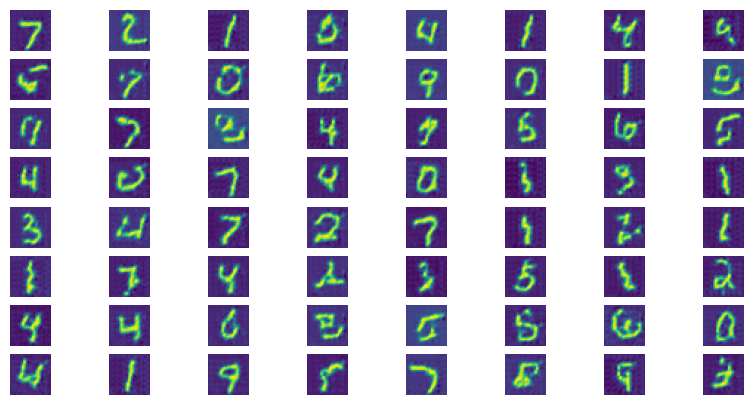

In [64]:
fig, ax = plt.subplots(8, 8, figsize=(10, 5))
for i in range(8):
    for j in range(8):
        reconstruction = model(testloader.dataset[i*8+j][0][None, :].float())[0]
        ax[i, j].imshow(reconstruction.detach().numpy().reshape(28, 28))
        ax[i, j].axis('off')